In [ ]:
# Show Data Profile
def show_data_profile(df):
  Data_dict = pd.DataFrame(df.dtypes)
  Data_dict = Data_dict.rename(columns={0: 'Data_Type'})
  Data_dict['Missing'] = df.isnull().sum()
  Data_dict['Missing_Pct'] = round((df.isnull().sum()/df.count())*100, 2)
  Data_dict['Unique'] = df.nunique()
  Data_dict['Count'] = df.count()
  Data_dict=Data_dict.reset_index()
  desc = df.describe(include='all').T
  desc = desc.drop(['count', 'unique'], axis=1)
  desc = desc.reset_index()
  Data_dict2 = pd.merge(Data_dict,desc,how='left', on=['index'])
  Data_dict2 = Data_dict2.fillna('-')#.sort_values(by=['Data_Type','Missing_Pct'],ascending=[True,False])
  Data_dict2 = Data_dict2.reset_index(drop=True).rename(columns={'index':'Features'})
  return Data_dict2

In [ ]:
import warnings
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=RuntimeWarning)


import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('mode.chained_assignment', None)

import re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns



#DATA PREPARATION

In [ ]:
#Load Data
df = pd.read_csv("online-retail-dataset.csv", sep=",",encoding='latin1',dtype={'CustomerID': str} )

In [ ]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


**Attribute Information:**

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  

**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.  

**Description**: Product (item) name. Nominal.  

**Quantity**: The quantities of each product (item) per transaction. Numeric.  

**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated.  

**UnitPrice**: Unit price. Numeric, Product price per unit in sterling.  

**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.  

**Country**: Country name. Nominal, the name of the country where each customer resides.

In [ ]:
#Rename column replacing whitespace with underscore
df.rename(columns= lambda x : x.replace(' ','_') if ' ' in x else x, inplace=True)
#Remove row with all columns are NA
df = df.dropna(how='all')

In [ ]:
show_data_profile(df)

,Features,Data_Type,Missing,Missing_Pct,Unique,Count,top,freq,mean,std,min,25%,50%,75%,max
0,InvoiceNo,object,0,0.00,25900,541909,573585,1114,-,-,-,-,-,-,-
1,StockCode,object,0,0.00,4070,541909,85123A,2313,-,-,-,-,-,-,-
2,Description,object,1454,0.27,4223,540455,WHITE HANGING HEART T-LIGHT HOLDER,2369,-,-,-,-,-,-,-
3,Quantity,int64,0,0.00,722,541909,-,-,9.55225,218.081,-80995,1,3,10,80995
4,InvoiceDate,object,0,0.00,23260,541909,10/31/2011 14:41,1114,-,-,-,-,-,-,-
5,UnitPrice,float64,0,0.00,1630,541909,-,-,4.61111,96.7599,-11062.1,1.25,2.08,4.13,38970
6,CustomerID,object,135080,33.20,4372,406829,17841,7983,-,-,-,-,-,-,-
7,Country,object,0,0.00,38,541909,United Kingdom,495478,-,-,-,-,-,-,-


In [ ]:
#Convert datetime column to datetime format
from datetime import datetime
df['InvoiceDate'] = df['InvoiceDate'].apply(lambda x:  datetime.strptime(x, '%m/%d/%Y %H:%M'))

In [ ]:
#Split column to alphabet and numeric
df['Status']=df['InvoiceNo'].apply(lambda x : ''.join(re.findall(r"[a-zA-Z]",str(x))))
df['Status']=df['Status'].replace('','S')
df['InvoiceNo']=df['InvoiceNo'].apply(lambda x : ''.join(re.findall(r"\d+",str(x))))

In [ ]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,S
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,S
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,S


In [ ]:
df['Status'].unique()

array(['S', 'C', 'A'], dtype=object)

## Feature Engineering

In [ ]:
#Add Revenue column
df['Revenue']=df['Quantity']*df['UnitPrice']

In [ ]:
#Add splitted datetime column
df['yearmonth']=df['InvoiceDate'].dt.strftime('%Y%m')
df['year']=df['InvoiceDate'].dt.strftime('%Y')
df['month']=df['InvoiceDate'].dt.strftime('%m')
df['date']=df['InvoiceDate'].dt.strftime('%d')
df['hour']=df['InvoiceDate'].dt.strftime('%H')
df['dayofweek']=df['InvoiceDate'].dt.strftime('%A') 
df['indexofweek']=(df['InvoiceDate'].dt.day - 1) // 7 + 1 #Index of week in a month (1-5)
df['quarter']=df['InvoiceDate'].dt.quarter # 1 = Jan-Mar, 2 = Apr-Jun, dst


In [ ]:
#Convert data type
df['indexofweek']=df['indexofweek'].astype(str)
df['quarter']=df['quarter'].astype(str)

In [ ]:
#Add first transaction
df['First_InvoiceDate']=df.groupby('CustomerID')['InvoiceDate'].transform(min)
#Add last transaction
df['Last_InvoiceDate']=df.groupby('CustomerID')['InvoiceDate'].transform(max)

In [ ]:
#Add num of days between current and first trx
df['days_current_first'] = (df['InvoiceDate']-df['First_InvoiceDate']).dt.days

In [ ]:
#Add num of days between last and first trx
df['days_last_first'] = (df['Last_InvoiceDate']-df['First_InvoiceDate']).dt.days

In [ ]:
#Add first transaction yearmonth
df['FirstInvoiceyearmonth']=df['First_InvoiceDate'].dt.strftime('%Y%m')

In [ ]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status,Revenue,yearmonth,year,month,date,hour,dayofweek,indexofweek,quarter,First_InvoiceDate,Last_InvoiceDate,days_current_first,days_last_first,FirstInvoiceyearmonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,S,15.30,201012,2010,12,01,08,Wednesday,1,4,2010-12-01 08:26:00,2011-02-10 14:38:00,0.0,71.0,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,S,20.34,201012,2010,12,01,08,Wednesday,1,4,2010-12-01 08:26:00,2011-02-10 14:38:00,0.0,71.0,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,S,22.00,201012,2010,12,01,08,Wednesday,1,4,2010-12-01 08:26:00,2011-02-10 14:38:00,0.0,71.0,201012


In [ ]:
show_data_profile(df)

,Features,Data_Type,Missing,Missing_Pct,Unique,Count,top,freq,first,last,mean,std,min,25%,50%,75%,max
0,InvoiceNo,object,0,0.00,25900,541909,573585,1114,-,-,-,-,-,-,-,-,-
1,StockCode,object,0,0.00,4070,541909,85123A,2313,-,-,-,-,-,-,-,-,-
2,Description,object,1454,0.27,4223,540455,WHITE HANGING HEART T-LIGHT HOLDER,2369,-,-,-,-,-,-,-,-,-
3,Quantity,int64,0,0.00,722,541909,-,-,-,-,9.55225,218.081,-80995,1,3,10,80995
4,InvoiceDate,datetime64[ns],0,0.00,23260,541909,2011-10-31 14:41:00,1114,2010-12-01 08:26:00,2011-12-09 12:50:00,-,-,-,-,-,-,-
5,UnitPrice,float64,0,0.00,1630,541909,-,-,-,-,4.61111,96.7599,-11062.1,1.25,2.08,4.13,38970
6,CustomerID,object,135080,33.20,4372,406829,17841,7983,-,-,-,-,-,-,-,-,-
7,Country,object,0,0.00,38,541909,United Kingdom,495478,-,-,-,-,-,-,-,-,-
8,Status,object,0,0.00,3,541909,S,532618,-,-,-,-,-,-,-,-,-
9,Revenue,float64,0,0.00,6204,541909,-,-,-,-,17.9878,378.811,-168470,3.4,9.75,17.4,168470


## Data Cleaning

In [ ]:
#Remove row with CustomerID=NA
df = df[~df['CustomerID'].isna()]
df['Description'] = df['Description'].fillna('')

In [ ]:
#Remove row with Negative Quantity
df = df[df['Quantity'] >0]

# COHORT ANALYSIS

## Number of User & Retention Rate

In [ ]:
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status,Revenue,yearmonth,year,month,date,hour,dayofweek,indexofweek,quarter,First_InvoiceDate,Last_InvoiceDate,days_current_first,days_last_first,FirstInvoiceyearmonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,S,15.30,201012,2010,12,01,08,Wednesday,1,4,2010-12-01 08:26:00,2011-02-10 14:38:00,0.0,71.0,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,S,20.34,201012,2010,12,01,08,Wednesday,1,4,2010-12-01 08:26:00,2011-02-10 14:38:00,0.0,71.0,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,S,22.00,201012,2010,12,01,08,Wednesday,1,4,2010-12-01 08:26:00,2011-02-10 14:38:00,0.0,71.0,201012


In [ ]:
df['CohortIndex']=((df['InvoiceDate']-df['First_InvoiceDate'])/np.timedelta64(1, 'M')).astype(int)
df[['InvoiceDate','First_InvoiceDate','CohortIndex']]

,InvoiceDate,First_InvoiceDate,CohortIndex
0,2010-12-01 08:26:00,2010-12-01 08:26:00,0
1,2010-12-01 08:26:00,2010-12-01 08:26:00,0
2,2010-12-01 08:26:00,2010-12-01 08:26:00,0
3,2010-12-01 08:26:00,2010-12-01 08:26:00,0
4,2010-12-01 08:26:00,2010-12-01 08:26:00,0
...,...,...,...
541904,2011-12-09 12:50:00,2011-08-18 15:44:00,3
541905,2011-12-09 12:50:00,2011-08-18 15:44:00,3
541906,2011-12-09 12:50:00,2011-08-18 15:44:00,3
541907,2011-12-09 12:50:00,2011-08-18 15:44:00,3


In [ ]:
cohort_data = df.groupby(['FirstInvoiceyearmonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()
cohort_data.head(3)

,FirstInvoiceyearmonth,CohortIndex,CustomerID
0,201012,0,886
1,201012,1,331
2,201012,2,327


### Number of User

In [ ]:
cohort_count = cohort_data.pivot_table(index = 'FirstInvoiceyearmonth',
                                       columns = 'CohortIndex',
                                       values = 'CustomerID')
cohort_count

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
FirstInvoiceyearmonth,,,,,,,,,,,,,
201012,886.0,331.0,327.0,364.0,311.0,352.0,335.0,309.0,329.0,351.0,392.0,470.0,80.0
201101,407.0,105.0,120.0,119.0,117.0,116.0,105.0,108.0,137.0,146.0,108.0,3.0,NaN
201102,373.0,78.0,95.0,103.0,75.0,101.0,91.0,96.0,108.0,82.0,2.0,NaN,NaN
201103,438.0,82.0,97.0,96.0,79.0,88.0,106.0,110.0,90.0,10.0,NaN,NaN,NaN
201104,297.0,77.0,52.0,61.0,53.0,66.0,72.0,68.0,6.0,NaN,NaN,NaN,NaN
201105,278.0,54.0,43.0,54.0,71.0,62.0,70.0,3.0,NaN,NaN,NaN,NaN,NaN
201106,234.0,36.0,46.0,58.0,64.0,64.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
201107,187.0,35.0,40.0,42.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201108,167.0,35.0,48.0,36.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


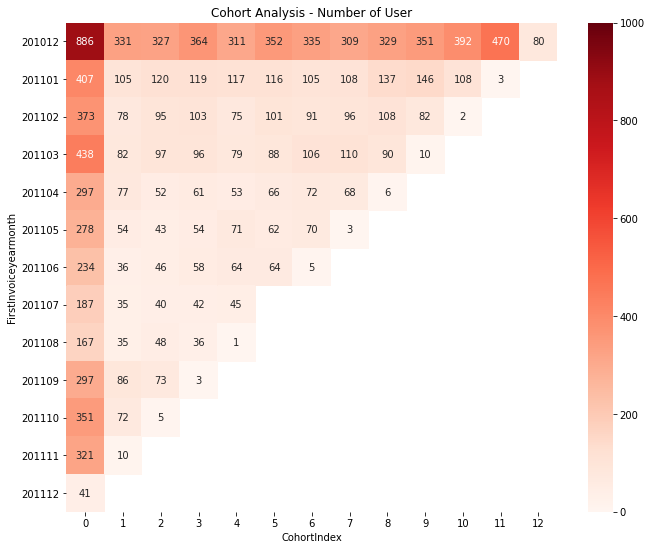

In [ ]:
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Number of User')
sns.heatmap(data = cohort_count, 
            annot = True, 
            fmt = '.3g', 
            vmin = 0,
            vmax = 1000,
            cmap = "Reds")
plt.show()

### Retention Rate

In [ ]:
cohort_size = cohort_count.iloc[:,0]
retention = cohort_count.divide(cohort_size, axis = 'rows')
retention.round(3) * 100

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
FirstInvoiceyearmonth,,,,,,,,,,,,,
201012,100.0,37.4,36.9,41.1,35.1,39.7,37.8,34.9,37.1,39.6,44.2,53.0,9.0
201101,100.0,25.8,29.5,29.2,28.7,28.5,25.8,26.5,33.7,35.9,26.5,0.7,NaN
201102,100.0,20.9,25.5,27.6,20.1,27.1,24.4,25.7,29.0,22.0,0.5,NaN,NaN
201103,100.0,18.7,22.1,21.9,18.0,20.1,24.2,25.1,20.5,2.3,NaN,NaN,NaN
201104,100.0,25.9,17.5,20.5,17.8,22.2,24.2,22.9,2.0,NaN,NaN,NaN,NaN
201105,100.0,19.4,15.5,19.4,25.5,22.3,25.2,1.1,NaN,NaN,NaN,NaN,NaN
201106,100.0,15.4,19.7,24.8,27.4,27.4,2.1,NaN,NaN,NaN,NaN,NaN,NaN
201107,100.0,18.7,21.4,22.5,24.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201108,100.0,21.0,28.7,21.6,0.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


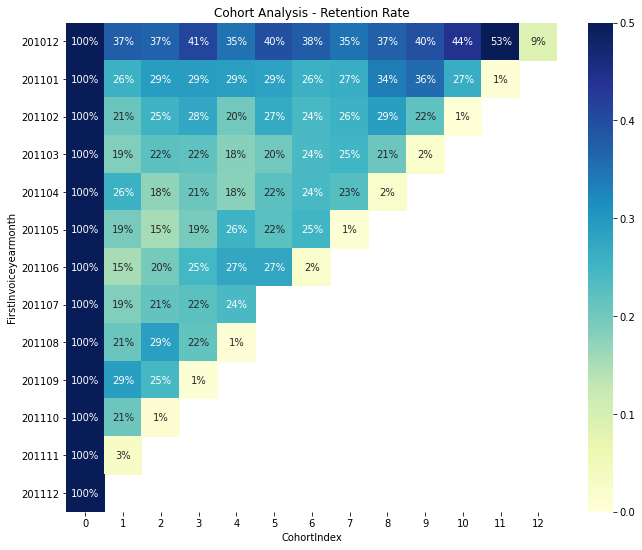

In [ ]:
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Retention Rate')
sns.heatmap(data = retention, 
            annot = True, 
            fmt = '.0%', 
            vmin = 0.0,
            vmax = 0.5,
            cmap = "YlGnBu")
plt.show()

## Average Quantity Sold

In [ ]:
cohort_data2 = df.groupby(['FirstInvoiceyearmonth', 'CohortIndex'])['Quantity'].mean().reset_index()
cohort_data2.head(3)

,FirstInvoiceyearmonth,CohortIndex,Quantity
0,201012,0,12.424570
1,201012,1,15.017769
2,201012,2,14.556521


In [ ]:
average_quantity  = cohort_data2.pivot_table(index = 'FirstInvoiceyearmonth',
                                            columns = 'CohortIndex',
                                       values = 'Quantity').round(1)
average_quantity

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
FirstInvoiceyearmonth,,,,,,,,,,,,,
201012,12.4,15.0,14.6,16.1,14.1,14.3,15.6,19.1,16.6,18.2,17.6,12.7,15.4
201101,16.5,15.1,11.3,14.0,14.1,15.4,14.7,14.3,12.0,8.7,9.4,15.7,NaN
201102,11.4,12.2,18.4,11.3,11.9,14.0,13.7,13.0,11.0,12.2,30.0,NaN,NaN
201103,10.0,12.3,12.4,10.3,14.2,14.5,11.1,14.9,10.1,9.9,NaN,NaN,NaN
201104,10.0,8.9,12.8,11.0,11.3,9.1,9.6,9.4,5.6,NaN,NaN,NaN,NaN
201105,11.2,11.8,12.6,11.1,10.3,8.2,48.9,15.2,NaN,NaN,NaN,NaN,NaN
201106,10.9,13.4,12.8,11.6,11.0,9.5,11.2,NaN,NaN,NaN,NaN,NaN,NaN
201107,10.1,8.9,8.0,6.9,6.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201108,9.1,5.0,6.5,7.3,10.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


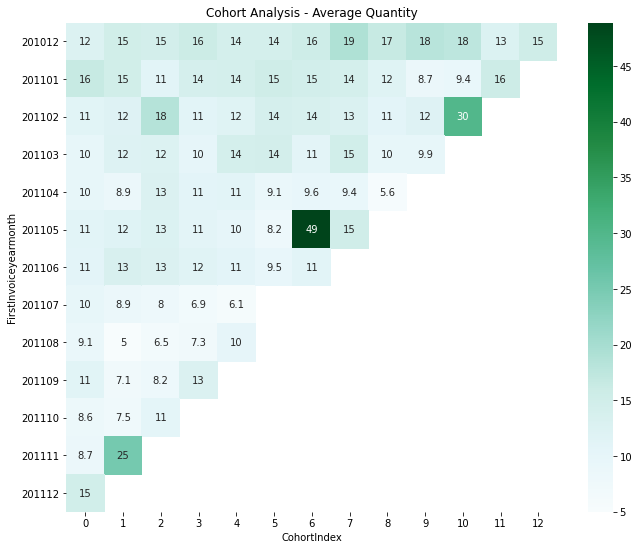

In [ ]:
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Average Quantity')
sns.heatmap(data = average_quantity, 
            annot = True, 
            cmap = "BuGn")
plt.show()

## Average Sales (Revenue)

In [ ]:
cohort_data3 = df.groupby(['FirstInvoiceyearmonth', 'CohortIndex'])['Revenue'].mean().reset_index()
cohort_data3.head(3)

,FirstInvoiceyearmonth,CohortIndex,Revenue
0,201012,0,22.401632
1,201012,1,26.765464
2,201012,2,24.713924


In [ ]:
average_sales  = cohort_data3.pivot_table(index = 'FirstInvoiceyearmonth',
                                           columns = 'CohortIndex',
                                      values = 'Revenue').round(1)
average_sales

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
FirstInvoiceyearmonth,,,,,,,,,,,,,
201012,22.4,26.8,24.7,26.9,21.6,28.1,26.8,31.6,27.0,35.5,31.3,21.8,27.8
201101,25.7,27.9,19.9,26.3,25.2,27.1,22.5,24.1,24.5,17.3,18.7,57.7,NaN
201102,17.8,17.7,22.4,17.6,16.9,19.3,22.9,21.8,19.1,21.9,51.2,NaN,NaN
201103,17.7,20.3,22.2,17.1,20.9,21.4,18.3,20.4,15.6,11.3,NaN,NaN,NaN
201104,17.1,18.2,23.8,16.7,19.2,15.2,14.8,15.6,9.5,NaN,NaN,NaN,NaN
201105,20.2,19.4,20.8,17.9,15.7,14.6,97.5,19.7,NaN,NaN,NaN,NaN,NaN
201106,23.5,17.6,16.9,20.1,15.5,16.5,14.1,NaN,NaN,NaN,NaN,NaN,NaN
201107,15.3,15.1,12.6,11.4,10.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201108,15.6,12.0,15.8,16.3,19.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


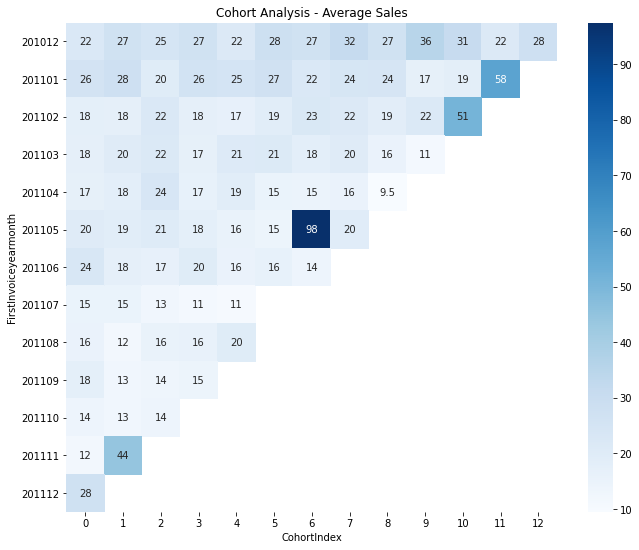

In [ ]:
plt.figure(figsize = (11,9))
plt.title('Cohort Analysis - Average Sales')
sns.heatmap(data = average_sales, 
            annot = True, 
            cmap = "Blues")
plt.show()